<div align="center">

<img src="../images/logo_isel.png" alt="ISEL" width="400"/>

<br><br>

**Instituto Superior de Engenharia de Lisboa**  
Licenciatura em Engenharia Informática e Multimédia  

<br><br>

### <u>Processamento de Imagem e Visão (PIV)</u>  
**Semestre de Inverno 25/26**

<br>

## 1º Trabalho Prático
**Contagem e Classificação de Peças LEGO**

<br><br><br>

<div align="left">

**Trabalho realizado por:**  
Miguel Cordeiro — nº 49765 — LEIM51N Grupo x  
Bruno Santos — nº 45096 — LEIM51N Grupo x  

**Docente:** Eng.º Nuno Silva 

</div>

</div>


### 1. Introdução

<div style="text-align: justify">
Neste trabalho, pretende-se desenvolver um algoritmo que seja capaz de contar um conjunto de peças de lego retangulares que foram colocadas em cima de uma mesan em que, a imagem seja captada por uma câmera fixa e com uma luminosidade (fonte de luz) também fixa. Esta contagem não pode ser feita através da cor e o algoritmo é desenvolvido através da biblioteca de funções OpenCV, uma biblioteca usada na programação de aplicações de visão em tempo real para a linguagem de programação Python.

Este algoritmo conta as peças com base nas suas dimensões. As dimensões a serem consideradas são ***2x2***, ***2x4***, ***2x6*** e ***2x8***. Qualquer outra peça que não se enquadre nestes formatos ou cujo o formato não seja perceptivel mesmo após o processamento das imagens e aplicação do algoritmo será considerada como ***Indefinida***.

Além da contagem de peças, o algoritmo irá tratar devidamente algumas perturbações que possam alterar as contagens, nomeadamente sombras, outras peças de lego no campo de visão e o contacto entre peças de lego.

**Conceitos Teóricos**

> Limiar Local: O limiar local é o valor de corte calculado para cada zona da imagem, em vez de um único valor global.

> Histograma de Imagens: É uma representação gráfica que mostra a distribuição de intensidades dos pixeis de uma imagem. Esta representação gráfica é fundamental na análise de uma imagem pois permite visualizar o número de pixeis por nível de brilho, do mais escuro para o mais claro.

> Binarização: A Binarização é um processo no qual se transforma uma imagem colorida ou em tons de cinza numa imagem binária, isto é, uma imagem representada apenas por duas cores: Preto e Branco.
> Este processo envolve a aplicação de um threshold, que determina os pixeis da imagem original serão convertidos para pretos e os que são convertidos para branco.
> Uma das vantagens da Binarização é a redução da complexidade dos dados. Ao converter uma imagem em formato binário, os algoritmos de análise e processamento podem operar de forma mais eficiente, isto enquanto poupa tempo e recursos computacionais.

> Taxa Experimental de Erro (tee): é uma métrica utilizada na análise de dados e em diversas áreas da tecnologia da informação. Representa a proporção de erros relativamente ao total de tentativas ou de operações realizadas. Este é calculado dividindo o número de classificações erradas pelo número de testes realizados.
<div align="center">
<img src="../images/tee.png" alt="tee" width="150"/>
</div>

> Taxa Experimental de Rejeições (ter): é uma métrica utilizada na análise de dados e em diversas áreas da tecnologia da informação. Representa a proporção de rejeições relativamente ao total de tentativas ou de operações realizadas. Este é calculado dividindo o número de classificações rejeitadas pelo número de testes realizados.

<div align="center">
<img src="../images/ter.png" alt="tee" width="150"/>
</div>
</div>

    - Bibliotecas Importadas

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox
import math

### 2. Leitura de Imagens

Neste capitulo iremos ler todo o data-set de imagens que nos foi fornecido pelo professor Nuno Silva. Estas serviram de testes para conseguirmos abrangir todos os casos possiveis que nos dificultam na separação de objetos.

(530, 706, 3)
(530, 706)


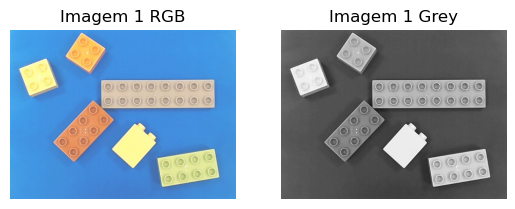

In [2]:
# Paths do data-set
paths = [
    "../images/lego01.jpg",
    "../images/lego02.jpg",
    "../images/lego04.jpg",
    "../images/lego09.jpg",
    "../images/lego10.jpg",
    "../images/lego11.jpg",
    "../images/lego12.jpg",
    "../images/lego13.jpg",
    "../images/lego21.jpg",
    "../images/lego22.jpg",
    "../images/lego23.jpg",
    "../images/lego25.jpg",
    "../images/lego30.jpg",
    "../images/lego32.jpg",
]

# Ler imagens
imgs = [cv2.imread(p) for p in paths]

# Converter para RGB
img_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

# Passar Imagem para Tons de Cinzento
img_gray = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in paths]

# Canais de cores = 3
print(np.shape(imgs[1]))
print(np.shape(img_gray[1]))

# Mostrar imagem RGB
plt.subplot(1,2,1)
plt.imshow(img_rgb[1])
plt.title("Imagem 1 RGB")
plt.axis("off")



# Mostrar imagem Grey
plt.subplot(1,2,2)
plt.imshow(img_gray[1], cmap="gray")
plt.title("Imagem 1 Grey")
plt.axis("off")
plt.show()

Antes de passarmos para a binarização decidimos separar a imagem nos 3 canais de cor (R, G, B).

    - Nota: Este modulo foi feito após a primeira tentativa de binarização.

Ao analisar o histograma, concluímos que o canal vermelho apresenta a melhor separação de intensidades entre o fundo e as peças, o que facilita a aplicação de um threshold simples para isolar as peças da mesa.

Nesta etapa do projeto, chegamos então à conclusão, a partir do histograma com os canais de cor que o valor de Threshold que iremos usar seria, mais ou menos, 110.

Em termos práticos, neste canal de cor (Vermelho), o fundo representaria a aproximação da ausencia de cor (valor 0) e as peças a aproximação da cor vermelha (valor 255).

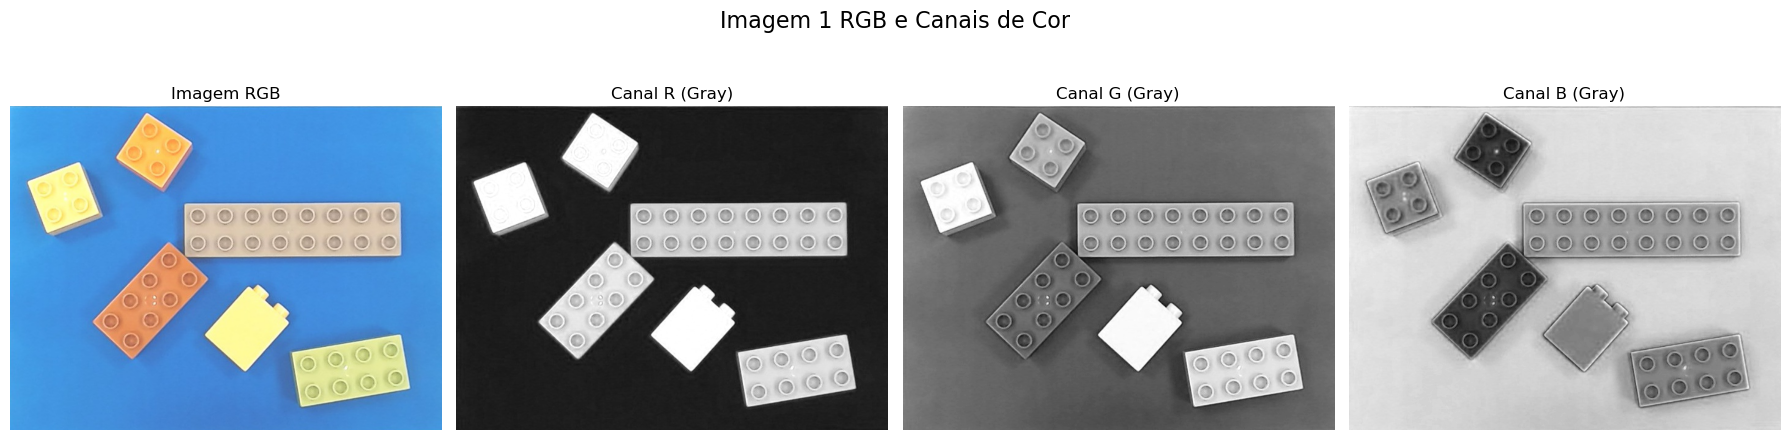

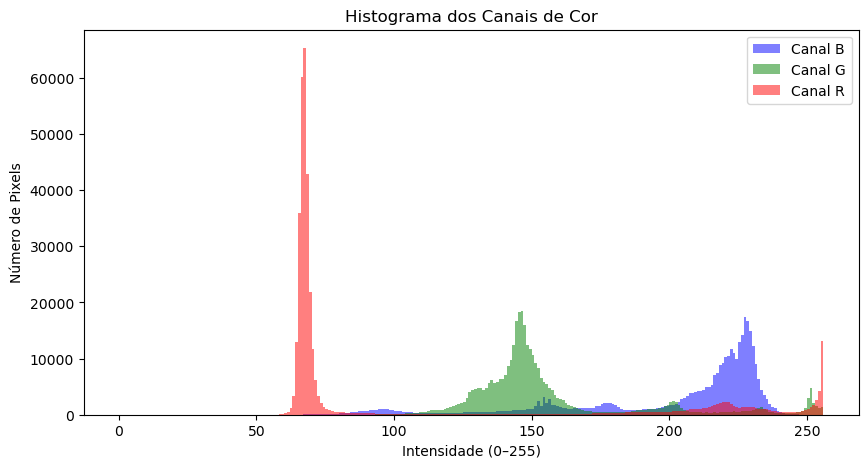

In [3]:
# Separa canais já em RGB (ordem: R, G, B)
r, g, b = cv2.split(img_rgb[1])
zeros = np.zeros_like(r)

# cria uma cópia independente dos valores do canal, preservando as intensidades originais (0–255)
gray_red = r.copy()
gray_green = g.copy()
gray_blue = b.copy()

# Plot dos canais de cor a escala de cinzentos

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle("Imagem 1 RGB e Canais de Cor", fontsize=16)

# Imagem original
axes[0].imshow(img_rgb[1])
axes[0].set_title("Imagem RGB")
axes[0].axis("off")

# Canal R
axes[1].imshow(gray_red, cmap='gray')
axes[1].set_title("Canal R (Gray)")
axes[1].axis("off")

# Canal G
axes[2].imshow(gray_green, cmap='gray')
axes[2].set_title("Canal G (Gray)")
axes[2].axis("off")

# Canal B
axes[3].imshow(gray_blue, cmap='gray')
axes[3].set_title("Canal B (Gray)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

# Plot do Histograma (canais de cor)
plt.figure(figsize=(10,5))
plt.title("Histograma dos Canais de Cor")
plt.xlabel("Intensidade (0–255)")
plt.ylabel("Número de Pixels")

plt.hist(b.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.5, label='Canal B')
plt.hist(g.ravel(), bins=256, range=[0, 256], color='green', alpha=0.5, label='Canal G')
plt.hist(r.ravel(), bins=256, range=[0, 256], color='red', alpha=0.5, label='Canal R')

plt.legend()
plt.show()

Célula Adicional para contruir os canais de cor das restantes imagens

In [4]:
# Separa canais já em RGB (ordem: R, G, B)
resultados = [cv2.split(img) for img in img_rgb]
r_list, g_list, b_list = zip(*resultados)

zeros_list = [np.zeros_like(r) for r in r_list]

gray_red_list   = [r.copy() for r in r_list]
gray_green_list = [g.copy() for g in g_list]
gray_blue_list  = [b.copy() for b in b_list]

### 3. Binarização

Começamos o processo de binarização, antes de descobrir a melhor forma de analisar a imagem e a separação de canais de cor (R, G, B). Deste modo, dividimos esta secção em duas tentativas, sendo a segunda a correta, com o melhor resultado de Binarização.

    - Primeira Tentativa

Usamos um filtro Gaussian Blur para reduzir o ruido. Um filtro Gaussiano é um filtro passa-baixa que remove os componentes de alta frequência. o Gaussian Blur calcula a média ponderada dos pixeis vizinhos a cada ponto da imagem. Quanto maior o raio do filtro, mais suave será o efeito aplicado. Isto sucede porque este filtro realça melhor quanto mais próximo os pixeis estiverem do ponto central, o que resulta numa transição suave entre cores.

In [5]:
# Suavizar ligeiramente para reduzir ruído
img_blur_1t = cv2.GaussianBlur(gray_red_list[1], (5, 5), 0)

Para binarização precisavamos usar um Threshold para converter a imagem (cinzento com o filtro Gaussian aplicado) em uma imagem binária. 

Em vez de um Threshold Simples (dado em aula), optamos por usar um threshold adaptativo porque embora todas as imagens terem um background de uma só cor definida este adapta-se melhor a variações de luz local e lida bem com sombras.

Parametros:
- blockSize: Tamanho da vizinhança.
    - Testamos vários valores para o tamanho da vizinhança para conseguirmos obter o melhor resultado de binarização, embora sempre valores impares (com objetivo de existir sempre um centro para o pixel a ser analisado).
- C: Ajusta a agressividade do filtro.



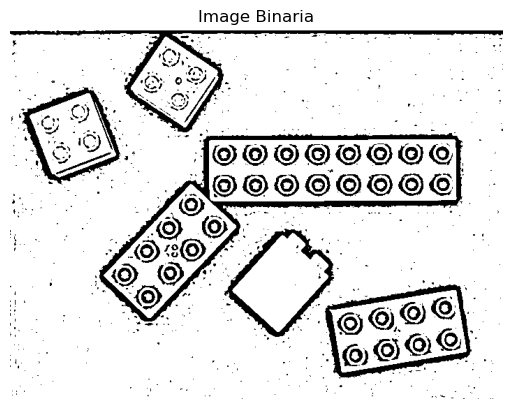

In [6]:
# Threshold adaptativo
blockSize = 15 # blockSize: tamanho da vizinhança (impar)
C = 2 # agressividade do filtro
adaptativeThreshold = cv2.adaptiveThreshold(img_blur_1t, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C)

# Mostrar imagem
plt.imshow(adaptativeThreshold, cmap="gray")
plt.title("Image Binaria")
plt.axis("off")  # Remove os eixos
plt.show()

Como já brevemente referido no Markdown em cima, esta tentativa foi realizada com o canal de cor simples em Gray apenas. Complicamos o processo para chegar ao resultado mais esperado e depois chegamos à conclusão que, a partir da separação em canais de cor (R, G, B) conseguiriamos obter o melhor resultado mesmo antes de efetuarmos filtros e binarização.

    - Segunda Tentativa

Nesta segunda tentativa, a correta, começamos por aplicar um filtro do tipo GaussianBlur com o objetivo de suavizar o ruído presente na imagem.

Este filtro realiza uma média ponderada das intensidades dos pixels vizinhos, reduzindo variações causadas por iluminação ou pequenas imperfeições no fundo, o que facilita a etapa de binarização.

De seguida, aplicamos um Threshold (Binarização) com o valor a 85, retirado no histograma dos canais de cor e conseguimos obter um resultado muito perto do resultado esperado. Este valor permite então criar um barreira entre o que são valores 1 (Cor) e o que são valores 0 (Ausencia de Cor), separando assim por completo as peças do fundo.

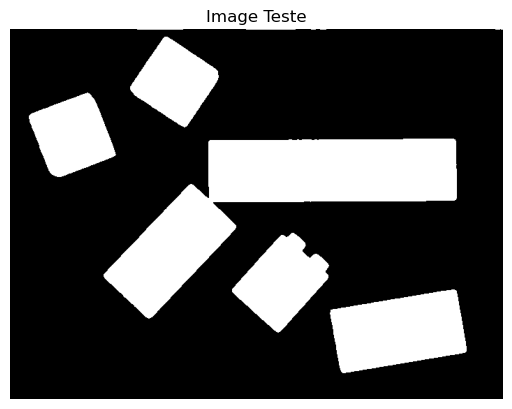

In [7]:
# Suavizar ruído
gr_blur = cv2.GaussianBlur(gray_red_list[1], (5, 5), 0)
T, bw = cv2.threshold(gr_blur, 110, 255, cv2.THRESH_BINARY)

plt.imshow(bw, cmap="gray")
plt.title("Image Teste")
plt.axis("off")
plt.show()


Realizamos todos os plots dos casos possiveis para podermos alinhar quais os proximos passos para melhoramento da imagem.

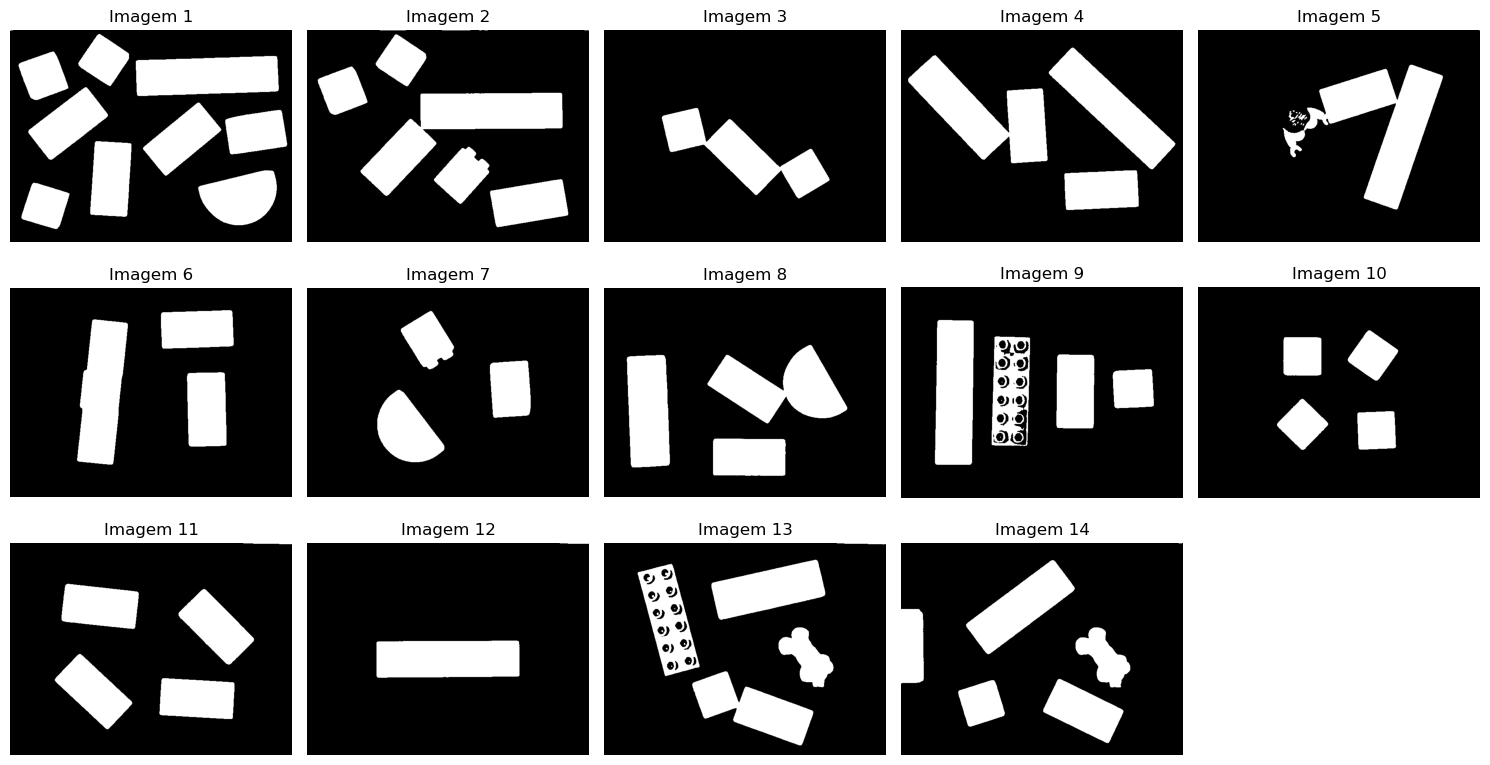

In [8]:
gr_blur_list = [cv2.GaussianBlur(img, (5, 5), 0) for img in gray_red_list]


threshold = 110
T_list, bw_list = zip(*[cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY) for img in gr_blur_list])



# Plots

titulos = [
    "Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5",
    "Imagem 6", "Imagem 7", "Imagem 8", "Imagem 9", "Imagem 10",
    "Imagem 11", "Imagem 12", "Imagem 13", "Imagem 14"
]

plt.figure(figsize=(15, 8))

for i in range(14):
    plt.subplot(3, 5, i + 1)
    plt.imshow(bw_list[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### 4. Melhoramento da Imagem

Com estes novos plots das binarizações em todos os casos, conseguimos tirar a conclusão de a existência de novos problemas. A existencia de buracos nas imagens 9 e 13 e algumas peças que tocam umas nas outras, dificultando assim o processo de separação de objetos.

Para retirar esse efeito vamos usar 4 funções:

    - Função Close - Fechar Buracos

    - Função Erode - Corroi Objetos

    - Função Dilate - Dilata Objetos (cantos ligeiramente arredondados)

    - Função Open - Abrir Buracos

Comecei por definir o valor de Kernel para os métodos MorphologyEx (Open and Close) e o valor de Element para os métodos Erode e Dilate.

O valor de kernel define a “área de influência” da operação morfológica.
- quanto maior for o kernel, maior a área afetada pela operação;

- quanto menor, mais suave e localizado é o efeito

O valor de Element (elemento estruturante) funciona como o Kernel mas para as funções de Erode e Dilate. Diferimos o nome para termos valores de Kernel diferentes dos valores para o Close e Open.

In [9]:
kernel = np.ones((13,13), np.uint8)
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (75,75))

A partir do uso das seguintes funções em baixo, fomos testando vários valores de kernel e element:

**Função MorphologyEx (CLOSE)**

Esta função preenche pequenas regiões pretas no interior das peças brancas, tornando as formas mais sólidas e contínuas.

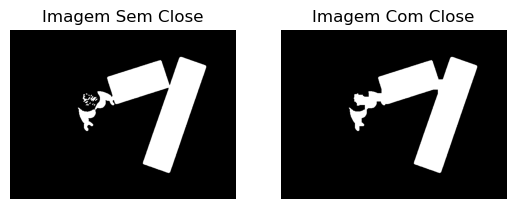

In [10]:
# Fechar Buracos
# Fui ajustando o valor de kernel para conseguir prencher os buracos da peça exemplo que estou a usar.
img_closed = cv2.morphologyEx(bw_list[4], cv2.MORPH_CLOSE, kernel)
plt.subplot(1,2,1)
plt.imshow(bw_list[4], cmap='gray')
plt.title("Imagem Sem Close")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_closed, cmap='gray')
plt.title("Imagem Com Close")
plt.axis("off")
plt.show()

**Função Erode**

Reduz ligeiramente o tamanho das peças brancas, separando objetos que se encontram colados.

Ajustamos o valor da variavel Element para reduzirmos os objetos com objetivo de posteriormente voltarmos a aumentar ligeiramente, arredondado e separando-os uns dos outros.

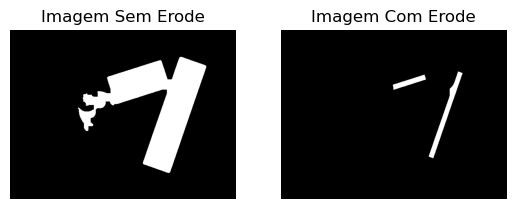

In [11]:
img_erode = cv2.erode(img_closed, element, iterations=1)

plt.subplot(1,2,1)
plt.imshow(img_closed, cmap='gray')
plt.title("Imagem Sem Erode")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_erode, cmap='gray')
plt.title("Imagem Com Erode")
plt.axis("off")
plt.show()

**Função Dilate**

Faz crescer novamente as peças após a erosão, restaurando as suas dimensões originais sem voltar a uni-las.

Ajustamos o tamanho das peças para o original, com ambos os cantos arredondados, com objetivo de as separar.

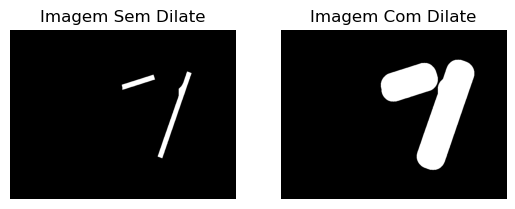

In [12]:
img_dilate = cv2.dilate(img_erode, element, iterations=1)

plt.subplot(1,2,1)
plt.imshow(img_erode, cmap='gray')
plt.title("Imagem Sem Dilate")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_dilate, cmap='gray')
plt.title("Imagem Com Dilate")
plt.axis("off")
plt.show()

**Função MorphologyEx (OPEN)**

Remove os pequenos elementos brancos isolados e suaviza o contorno dos objetos, garantindo uma segmentação mais limpa.

Ajustei o valor de Kernel de forma a que não interfira com o objetivo do close e que use bem o open, como por exemplo, na imagem 3 em que temos um pouco de branco a sair do objeto e queremos ajustar.

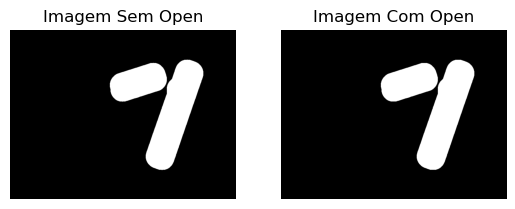

In [13]:
img_opened = cv2.morphologyEx(img_dilate, cv2.MORPH_OPEN,  kernel,  iterations=1)

plt.subplot(1,2,1)
plt.imshow(img_dilate, cmap='gray')
plt.title("Imagem Sem Open")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_opened, cmap='gray')
plt.title("Imagem Com Open")
plt.axis("off")
plt.show()

Decidimos, posteriormente, separar os valores de kernel para o Open e para o Close e os valores de Element para o Erode e o Dilate com o objetivo de tornar o sistema ainda mais preciso para todos os casos possiveis.

Para facilitar a procura do valor de Kernels e Elements, recorri ao OpenAI (ChatGPT – modelo GPT-5 Thinking) para me gerar um código com ipywidgets, garantindo tamanhos ímpares dos kernels e elements e aplicando as operações Close/Erode/Dilate/Open ao conjunto das 14 imagens binárias.

O código foi posteriormente revisto, testado e adaptado por mim. Adicionei possibilidade de alterar  as formas RECT/ELLIPSE/CROSS e removi uma funcionalidade não necessárias como "Link CLOSE/OPEN sizes".

PROMPT: Faça-me um painel interativo em Jupyter com ipywidgets para testar operações morfológicas do OpenCV nas 14 imagens binárias (bw1, bw2, ..., bw14). Pretendo conseguir de forma interativa mover os valores de Kernel Close, Kernel Open, Element Erode, Element Dilate e visualizar o resultado das funções de qualidade de imagem no plot.



In [14]:
# ------- utilitários -------
def odd(n):
    n = int(n)
    return n if n % 2 == 1 else n + 1

shape_map = {"RECT": cv2.MORPH_RECT, "ELLIPSE": cv2.MORPH_ELLIPSE, "CROSS": cv2.MORPH_CROSS}

def imageUpgrade_separado(image, kernel_close, kernel_open, element_erode, element_dilate):
    img_closed  = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
    img_erode   = cv2.erode(img_closed,  element_erode,  iterations=1)
    img_dilate  = cv2.dilate(img_erode,  element_dilate, iterations=1)
    img_opened  = cv2.morphologyEx(img_dilate, cv2.MORPH_OPEN, kernel_open, iterations=1)
    return img_opened

# ------- widgets -------
w_kclose_size  = widgets.IntSlider(value=3, min=1, max=101, step=2, description="CLOSE size")
w_kclose_shape = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="CLOSE shape")

w_kopen_size   = widgets.IntSlider(value=3, min=1, max=101, step=2, description="OPEN size")
w_kopen_shape  = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="OPEN shape")

w_ero_size     = widgets.IntSlider(value=3, min=1, max=101, step=2, description="ERODE size")
w_ero_shape    = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="ERODE shape")

w_dil_size     = widgets.IntSlider(value=3, min=1, max=101, step=2, description="DILATE size")
w_dil_shape    = widgets.Dropdown(options=["RECT","ELLIPSE","CROSS"], value="RECT", description="DILATE shape")

# ------- função principal (usa diretamente a tua bw_list!) -------
def run(kclose_size, kclose_shape, kopen_size, kopen_shape,
        ero_size, ero_shape, dil_size, dil_shape):

    # usa a lista/tuplo já existente (bw_list) – nada de globals()
    images = list(bw_list)

    ks_close = odd(kclose_size)
    ks_open  = odd(kopen_size)
    es_ero   = odd(ero_size)
    es_dil   = odd(dil_size)

    kernel_close = cv2.getStructuringElement(shape_map[kclose_shape], (ks_close, ks_close))
    kernel_open  = cv2.getStructuringElement(shape_map[kopen_shape],  (ks_open,  ks_open))
    element_ero  = cv2.getStructuringElement(shape_map[ero_shape],    (es_ero,  es_ero))
    element_dil  = cv2.getStructuringElement(shape_map[dil_shape],    (es_dil,  es_dil))

    results = [imageUpgrade_separado(img, kernel_close, kernel_open, element_ero, element_dil)
               for img in images]

    n = len(results)
    ncols = 4
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
    axes = np.array(axes).ravel() if nrows * ncols > 1 else np.array([axes])

    for i, (ax, img) in enumerate(zip(axes, results)):
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Imagem {i+1}")
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(
        f"CLOSE=({ks_close},{kclose_shape}) | "
        f"ERODE=({es_ero},{ero_shape}) | "
        f"DILATE=({es_dil},{dil_shape}) | "
        f"OPEN=({ks_open},{kopen_shape})",
        fontsize=10
    )
    plt.tight_layout()
    plt.show()

# ------- montar e mostrar o painel -------
ui = VBox([
    HBox([w_kclose_size, w_kclose_shape]),
    HBox([w_kopen_size,  w_kopen_shape]),
    HBox([w_ero_size,    w_ero_shape]),
    HBox([w_dil_size,    w_dil_shape]),
])

out = interactive_output(
    run,
    {
        "kclose_size": w_kclose_size,
        "kclose_shape": w_kclose_shape,
        "kopen_size": w_kopen_size,
        "kopen_shape": w_kopen_shape,
        "ero_size": w_ero_size,
        "ero_shape": w_ero_shape,
        "dil_size": w_dil_size,
        "dil_shape": w_dil_shape,
    }
)

display(ui, out)


Output()

Depois de alguns testes, estes foram os melhores valores definitivos foram encontrados:
- Kernel Close = 19
- Kernel Open = 3
- Element Erode = 49
- Element Dilate = 9

<img src="../images/image_upgrade_result.png" alt="result_upgrade" width="900"/>

Criei uma função que junta as 4 funções de melhoramento de imagem que iremos usar, com os mesmo valores de Kernel e Element decididos em cima.

In [15]:
def imageUpgrade(image, kernel_close, kernel_open, element_ero, element_dil):
    img_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
    img_erode = cv2.erode(img_closed, element_ero, iterations=1)
    img_dilate = cv2.dilate(img_erode, element_dil, iterations=1)
    img_opened = cv2.morphologyEx(img_dilate, cv2.MORPH_OPEN,  kernel_open,  iterations=1)
    return img_opened

Plot das Imagens apenas com Binarização, com motivos de comparação com o plot seguinte:

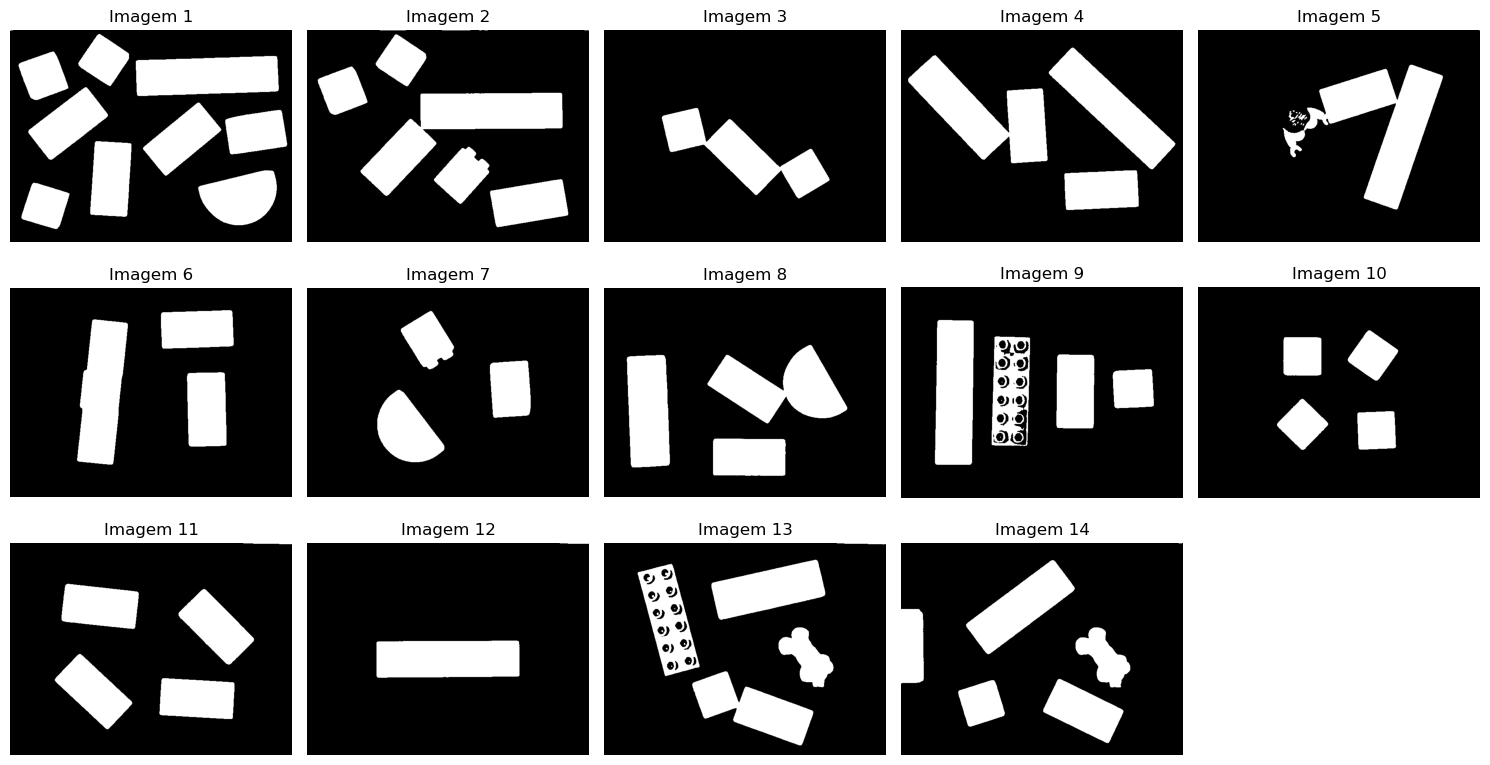

In [16]:
titulos = [
    "Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5",
    "Imagem 6", "Imagem 7", "Imagem 8", "Imagem 9", "Imagem 10",
    "Imagem 11", "Imagem 12", "Imagem 13", "Imagem 14"
]

plt.figure(figsize=(15, 8))

for i in range(14):
    plt.subplot(3, 5, i + 1)
    plt.imshow(bw_list[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

Aqui efetuamos a função de melhoramento de imagem para todas as imagens da nosa base de dados, com os melhores parametros encontrados para separação de peças e fundo.

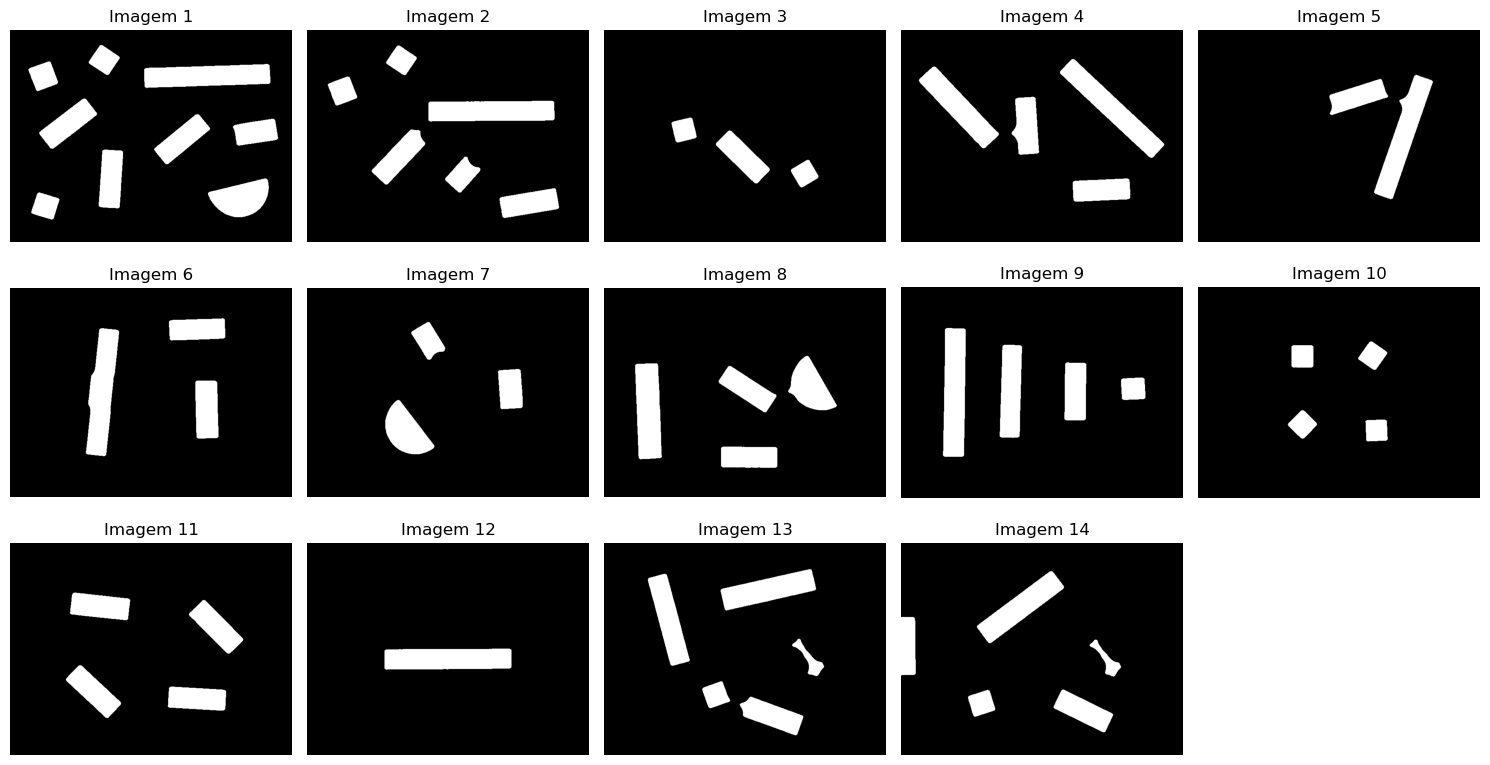

In [17]:
# Definir valores de kernel e element escolhidos em cima
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
kernel_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
element_ero  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (49,49))
element_dil  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))


updated_images = []

for i, img in enumerate(bw_list, start=1):
    result = imageUpgrade(img, kernel_close, kernel_open, element_ero, element_dil)
    updated_images.append(result)
    globals()[f"img_final{i}"] = result

titulos = [
    "Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5",
    "Imagem 6", "Imagem 7", "Imagem 8", "Imagem 9", "Imagem 10",
    "Imagem 11", "Imagem 12", "Imagem 13", "Imagem 14"
]

plt.figure(figsize=(15, 8))

for i in range(14):
    plt.subplot(3, 5, i + 1)
    plt.imshow(updated_images[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


### 5. Sistemas de Classificação

Começamos por definir um sistema de classificação, para isso, necessitamos de definir:
- Classes de Interesse
- Definir Sensores
- Extração de Caracteristicas (features)

E por fim definimos o classificador com base nestes 3 pontos.

**Classes de Interesse**

[2x2, 2x4, 2x6, 2x8]

Tudo o que não se classificar nestes 4 objetos será considerado classe de rejeição.

**Definir Sensores**

Usamos como sensores uma camera

**Extração de Caracteristicas (features)**

A partir da definição de sensores podemos comparar as caracteristicas em comum que retiramos dos objetos que pretendemos classificar, desde modo, irmos usar caracteristicas como a area.

### 6. Extração de Componentes Conexos

Nesta etapa o objetivo é identificar e separar cada uma das peças de lego presentes nas imagens que tratamos até agora.
Através da extração de componentes conexos, conseguimos detetar quais os conjuntos de píxeis que estão ligados entre si, correspondendo a objetos individuais.
Desta forma, é possível contar o número de peças em cada imagem e obter informações importantes sobre cada uma, como a sua área, posição, contorno ou orientação.

    - Tentativa A 
        findContours()

Comecei por experimentar a função findContours do OpenCV. Nesta função é possivel alterar dois atributos, por motivos de não tornar o projeto mais complexo testei primeiro os resultados com os parametros mais simples (cv2.RETR_EXTERNAL e cv2.CHAIN_APPROX_SIMPLE).

Com esta função, consigo analisar o contorno de diferentes objetos separados nas imagens binarizadas finais e calcular o numero de objetos existentes em cada.

Usamos o drawContours que desenha estes contornos dos objetos na imagem, para este efeito precisamos passar para BRG porque para destacar o contorno precisamos de uma imagem de 3 canais e nao apenas 2 como as nossas imagens binárias,

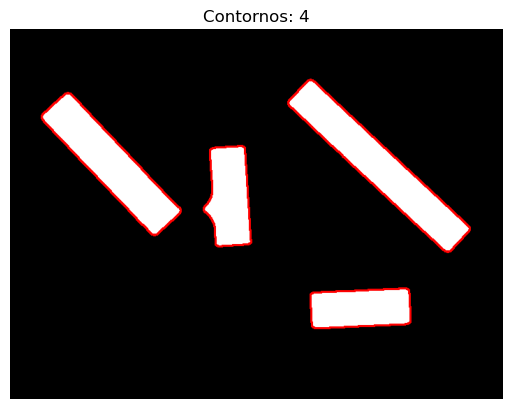

In [18]:
# Encontrar valores de conrtonos e hierarquia
contours, hierarchy = cv2.findContours(updated_images[3], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Copiar e converter a imagem para BGR
img_contours = cv2.cvtColor(updated_images[3], cv2.COLOR_GRAY2BGR)

# Desenhar contornos a verde
cv2.drawContours(img_contours, contours, -1, (0,0,255), 2)

# Plot do resultado para a Imagem updated_images[n] (alterar valor de n conforme imagem a ver)
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title(f"Contornos: {len(contours)}")
plt.axis("off")
plt.show()


Aplicamos a função usada em cima nas restantes imagens para testar o seu resultado em todo o data set.

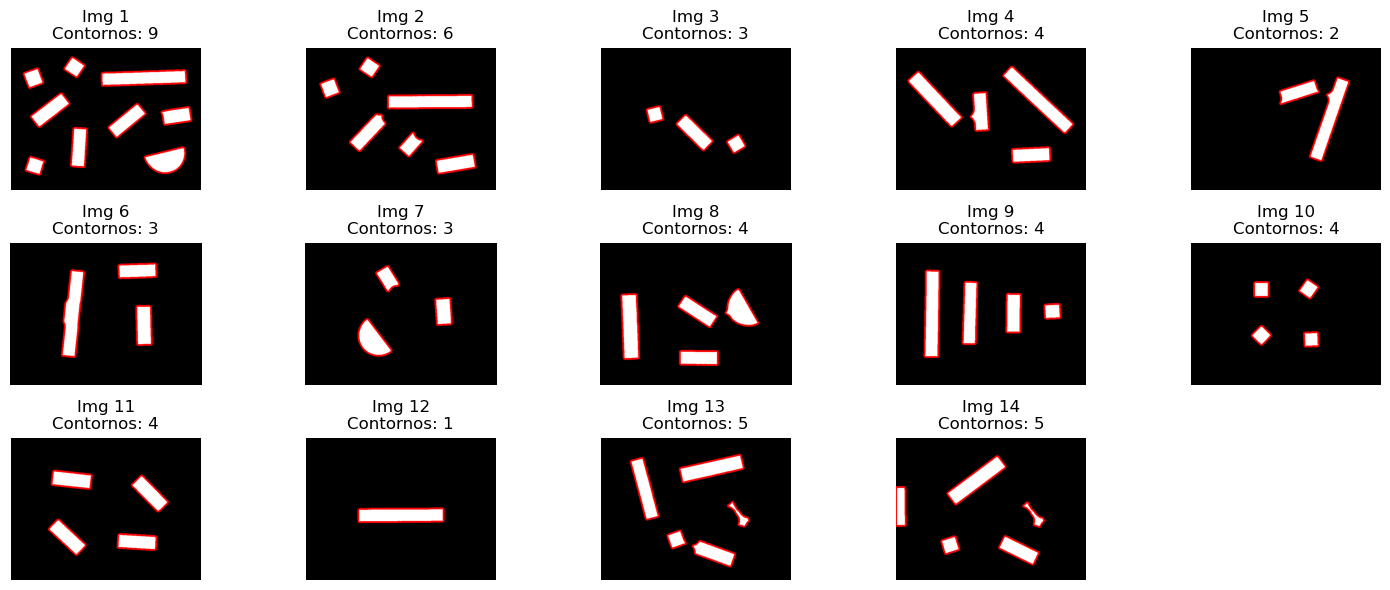

In [19]:
plt.figure(figsize=(15, 6))

for i, img_bw in enumerate(updated_images):
    # Encontrar contornos e hireraquia
    contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Converter para BGR e desenhar contornos
    img_contours = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)
    # Aumentei o ultimo valor para tornar o contorno mais visível
    cv2.drawContours(img_contours, contours, -1, (0, 0, 255), 5)

    # Plot de todas as imagens
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    plt.title(f"Img {i+1}\nContornos: {len(contours)}")
    plt.axis("off")

plt.tight_layout()
plt.show()


    - Tentativa B 
        connectedComponents()

Nesta segunda tentativa optei por usar a função connectedComponents(), uma função mais simples para contar o numero de componentes conexos.

Nesta função podemos escolher a conectividade (vizinhança), em que conectividade 4 representaria os pixeis conexos da vertical e horizontal, enquanto a conectividade 8 representaria tambem os pixeis conexos da diagonal representado 8 pixeis vizinhos.

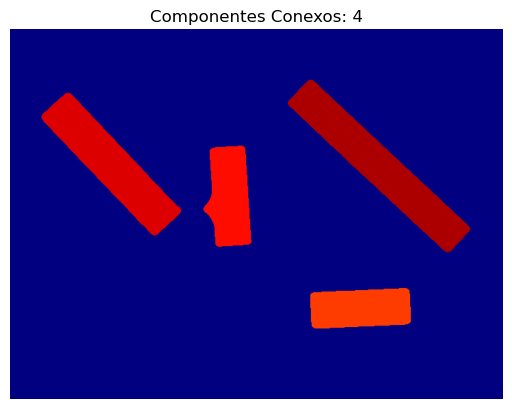

In [20]:
# Imagem binária 0-255 para 0-1
bw = (updated_images[3] > 0).astype(np.uint8)

# Obter Labels de componentes conexos
num_labels, labels = cv2.connectedComponents(bw, connectivity=8)

# Multipliquei por 500 para separar as labels do fundo
labels_color = cv2.applyColorMap((labels*500).astype(np.uint8), cv2.COLORMAP_JET)

# Plot resultado updated_images[n] (alterar valor de n conforme imagem a ver)
plt.imshow(cv2.cvtColor(labels_color, cv2.COLOR_BGR2RGB))
plt.title(f"Componentes Conexos: {num_labels - 1}")
plt.axis("off")
plt.show()


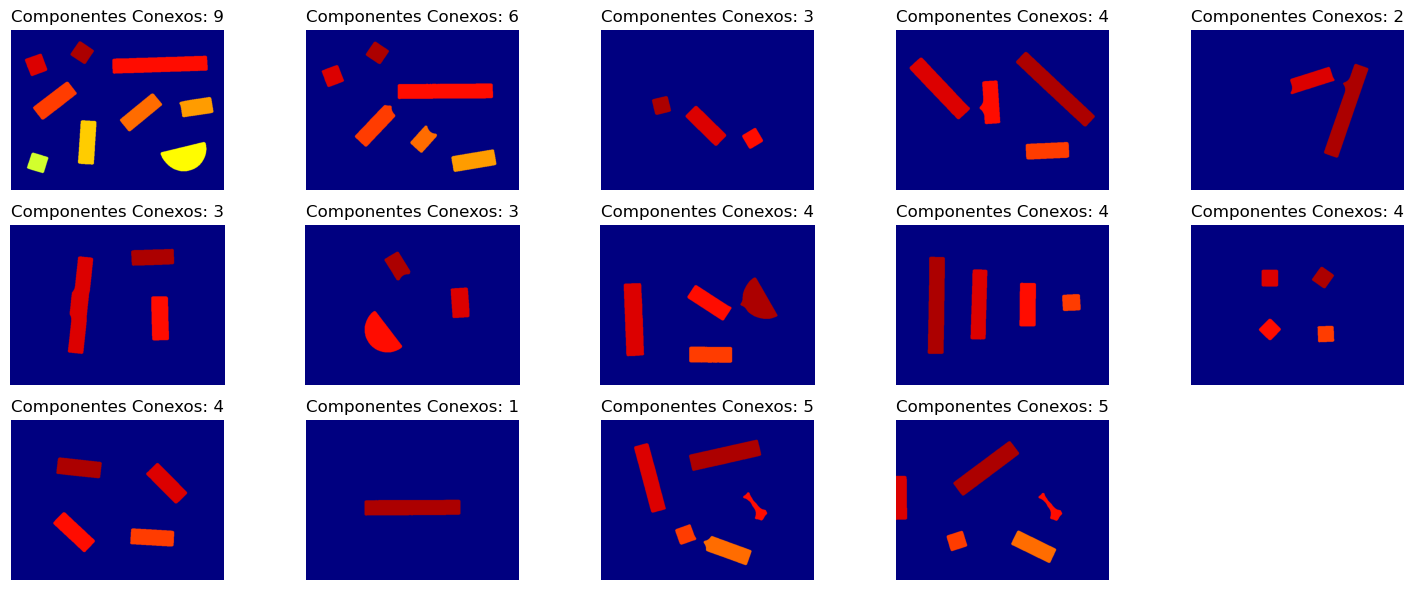

In [21]:
plt.figure(figsize=(15, 6))  # aumenta o tamanho do plot total

for i, img_bw in enumerate(updated_images):
    # Encontrar contornos
    num_labels, labels = cv2.connectedComponents(img_bw, connectivity=8)

    labels_color = cv2.applyColorMap((labels*500).astype(np.uint8), cv2.COLORMAP_JET)

    # Plots resultados
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(labels_color, cv2.COLOR_BGR2RGB))
    plt.title(f"Componentes Conexos: {num_labels - 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Optei por usar a Tentativa A, pois pretendo usar os contornos para analisar a area. Esta area vai me saber determinar que classe é a peça analisada.

Para nos facilitar a recolher as Features que definimos obter a opção A foi nos vais relevante pois temos a função contourArea que sera abordada no proximo capitulo.

### 7. Extracção de propriedades

No capitulo 5 (Sistemas de Classificação), abordamos e decidimos o sistema de classificação que iriamos definir.

Neste capitulo preocupamos-nos a explorar funções para proceder aos calculo da Feature "Area" em todo o data-set de imagens.

In [22]:
area_contorno1 = cv2.contourArea(contours[1])

print(f"Área do contorno 1: {area_contorno1} píxeis")

Área do contorno 1: 7394.5 píxeis


Decidi construir um array bidemensional que organiza as areas dos contornos calculados por imagem e calculamos todas as areas do nosso data-set.

In [23]:
bi_imagem_areas = []  # lista que vai guardar array bidimensional de imagens e suas areas respetivas

for i, img_bw in enumerate(updated_images):
    contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # calcular as áreas dos contornos das imagens
    areas = [cv2.contourArea(c) for c in contours if cv2.contourArea(c) > 50]
    bi_imagem_areas.append(areas)

print("Areas por imagem:")
for i, a in enumerate(bi_imagem_areas):
    print(f"Imagem {i+1}: {a}")


Areas por imagem:
Imagem 1: [3140.5, 9624.0, 7403.0, 5462.0, 7266.5, 7678.0, 15211.5, 3455.0, 3239.5]
Imagem 2: [7424.5, 3910.5, 7729.0, 15120.0, 3341.0, 3185.5]
Imagem 3: [2743.5, 7397.0, 2774.0]
Imagem 4: [7256.0, 7407.0, 12937.5, 15641.5]
Imagem 5: [6839.0, 15462.5]
Imagem 6: [7761.0, 16208.5, 6902.5]
Imagem 7: [9537.5, 5378.5, 4210.5]
Imagem 8: [7103.0, 7189.0, 13518.0, 9171.5]
Imagem 9: [3075.0, 7468.0, 11160.0, 16342.0]
Imagem 10: [2720.5, 2866.5, 2946.0, 2885.0]
Imagem 11: [7375.0, 7605.0, 7671.5, 7832.0]
Imagem 12: [15630.5]
Imagem 13: [7759.5, 2936.0, 2094.0, 11075.0, 12652.5]
Imagem 14: [3018.5, 7394.5, 2016.0, 5060.5, 12820.0]


### 8. Classificação de Objetos

Neste capitulo iremos finalizar a aplicação de classificação de peças lego.

Começamos por organizar as classes que pretendemos definir e a classe de rejeição, classe dedicada para objetos que não pretencem as classes que no enunciado foram pedidas para classificar.

Para cada classe a definir foi estabelecido dois valores de limiar (min e max) que definem o intervalo que corresponde a cada peça.

Para facilitar na obtenção dos valores criamos um plot com a area em cima de cada peça. Podemos alterar a imagem mudando o valor de i, representando o conjunto de imagens.

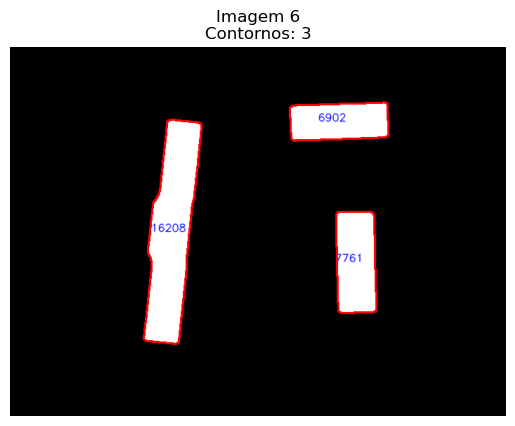

In [24]:
i_area = 5
img_bw = updated_images[i_area].copy()

# Encontrar contornos
contours, _ = cv2.findContours(img_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Converter para BGR e desenhar contornos
img_contours = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)

# Escrever área de cada contorno
for j, c in enumerate(contours):
    area = cv2.contourArea(c)
    M = cv2.moments(c)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.putText(img_contours, f"{int(area)}", (cx - 30, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    cv2.drawContours(img_contours, [c], -1, (0, 0, 255), 2)

# Mostrar imagem única
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title(f"Imagem {i_area+1}\nContornos: {len(contours)}")
plt.axis("off")
plt.show()


A partir do plot-teste calculamos o Range de cada classificação:
- 2x2 Min(2720) Max(3455)
- 2x4 Min(6839) Max(7832)
- 2x6 Min(11075) Max(13518)
- 2x8 Min(15120) Max(16342)

Na função de classificação desenvolvida a seguir, inseriu-se o min ligeiramente a baixo e o max ligeiramente acima para cobrir todos os casos possiveis.

In [25]:
def lego_class(area):
    if 2700 <= area <= 3500:
        return "Lego 2x2"
    elif 6800 <= area <= 7900:
        return "Lego 2x4"
    elif 11000 <= area <= 13600:
        return "Lego 2x6"
    elif 15100 <= area <= 16400:
        return "Lego 2x8"
    else:
        return "Rejeicao"
    
for i, areas in enumerate(bi_imagem_areas):
    classes = [lego_class(a) for a in areas]
    print(f"Imagem {i+1}: {classes}")

Imagem 1: ['Lego 2x2', 'Rejeicao', 'Lego 2x4', 'Rejeicao', 'Lego 2x4', 'Lego 2x4', 'Lego 2x8', 'Lego 2x2', 'Lego 2x2']
Imagem 2: ['Lego 2x4', 'Rejeicao', 'Lego 2x4', 'Lego 2x8', 'Lego 2x2', 'Lego 2x2']
Imagem 3: ['Lego 2x2', 'Lego 2x4', 'Lego 2x2']
Imagem 4: ['Lego 2x4', 'Lego 2x4', 'Lego 2x6', 'Lego 2x8']
Imagem 5: ['Lego 2x4', 'Lego 2x8']
Imagem 6: ['Lego 2x4', 'Lego 2x8', 'Lego 2x4']
Imagem 7: ['Rejeicao', 'Rejeicao', 'Rejeicao']
Imagem 8: ['Lego 2x4', 'Lego 2x4', 'Lego 2x6', 'Rejeicao']
Imagem 9: ['Lego 2x2', 'Lego 2x4', 'Lego 2x6', 'Lego 2x8']
Imagem 10: ['Lego 2x2', 'Lego 2x2', 'Lego 2x2', 'Lego 2x2']
Imagem 11: ['Lego 2x4', 'Lego 2x4', 'Lego 2x4', 'Lego 2x4']
Imagem 12: ['Lego 2x8']
Imagem 13: ['Lego 2x4', 'Lego 2x2', 'Rejeicao', 'Lego 2x6', 'Lego 2x6']
Imagem 14: ['Lego 2x2', 'Lego 2x4', 'Rejeicao', 'Rejeicao', 'Lego 2x6']


Para finalizar vamos classificar a imagem i_cls com os parametros definidos na função lego_class.

Para facilitarmos a visualização, iremos atribuir cores verdes as classes que queremos extrair e uma cor vermelha no contorno da classe de rejeição caso seja encontrada, acrescentamos tambem um pequeno texto com o tipo de peça classificado.

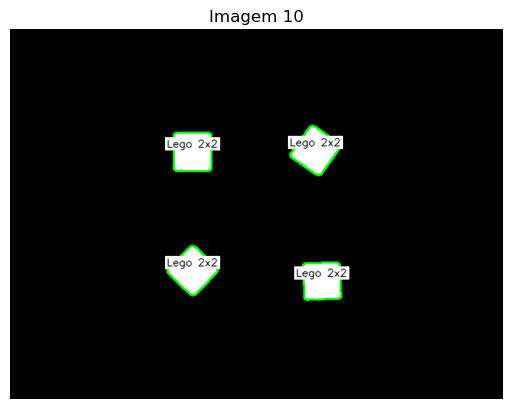

In [26]:
CLASS_COLOR = {
    "Lego 2x2": (0, 255, 0),
    "Lego 2x4": (0, 255, 0),
    "Lego 2x6": (0, 255, 0),
    "Lego 2x8": (0, 255, 0),
    "Rejeicao": (0, 0, 255),
}

i_cls = 9  # imagem 10

img_bw_cls = updated_images[i_cls].copy()
contours_cls, _ = cv2.findContours(img_bw_cls, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours_cls = cv2.cvtColor(img_bw_cls, cv2.COLOR_GRAY2BGR)

for c in contours_cls:
    area = cv2.contourArea(c)
    label = lego_class(area)  # classificar de acordo com a área
    color = CLASS_COLOR.get(label, (0, 0, 255))  # obter cor

    # Desenhar o contorno na imagem com a cor da classe
    cv2.drawContours(img_contours_cls, [c], -1, color, 2)


# Escrever o nome da classe sobre cada peça
for c in contours_cls:
    area = cv2.contourArea(c)
    label = lego_class(area)

    # Centralizar o texto
    M = cv2.moments(c)
    if M["m00"] == 0:
        continue
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Caixa branca
    (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    x0, y0 = cx - tw // 2, cy - th // 2
    cv2.rectangle(img_contours_cls, (x0 - 2, y0 - th - 2), (x0 + tw + 2, y0 + 4),
                  (255, 255, 255), -1)

    # Escrever o nome da classe sobre a peça
    cv2.putText(img_contours_cls, label, (x0, y0),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# Plot
plt.imshow(cv2.cvtColor(img_contours_cls, cv2.COLOR_BGR2RGB))
plt.title(f"Imagem {i_cls+1}")
plt.axis("off")
plt.show()

Por fim e para facilitar a inserção de dados para o próximo capítulo, vamos fazer um plot de todo o data-set de imagens fornecidas pelo professor Nuno Silva, com o sistema de classificação implementado.

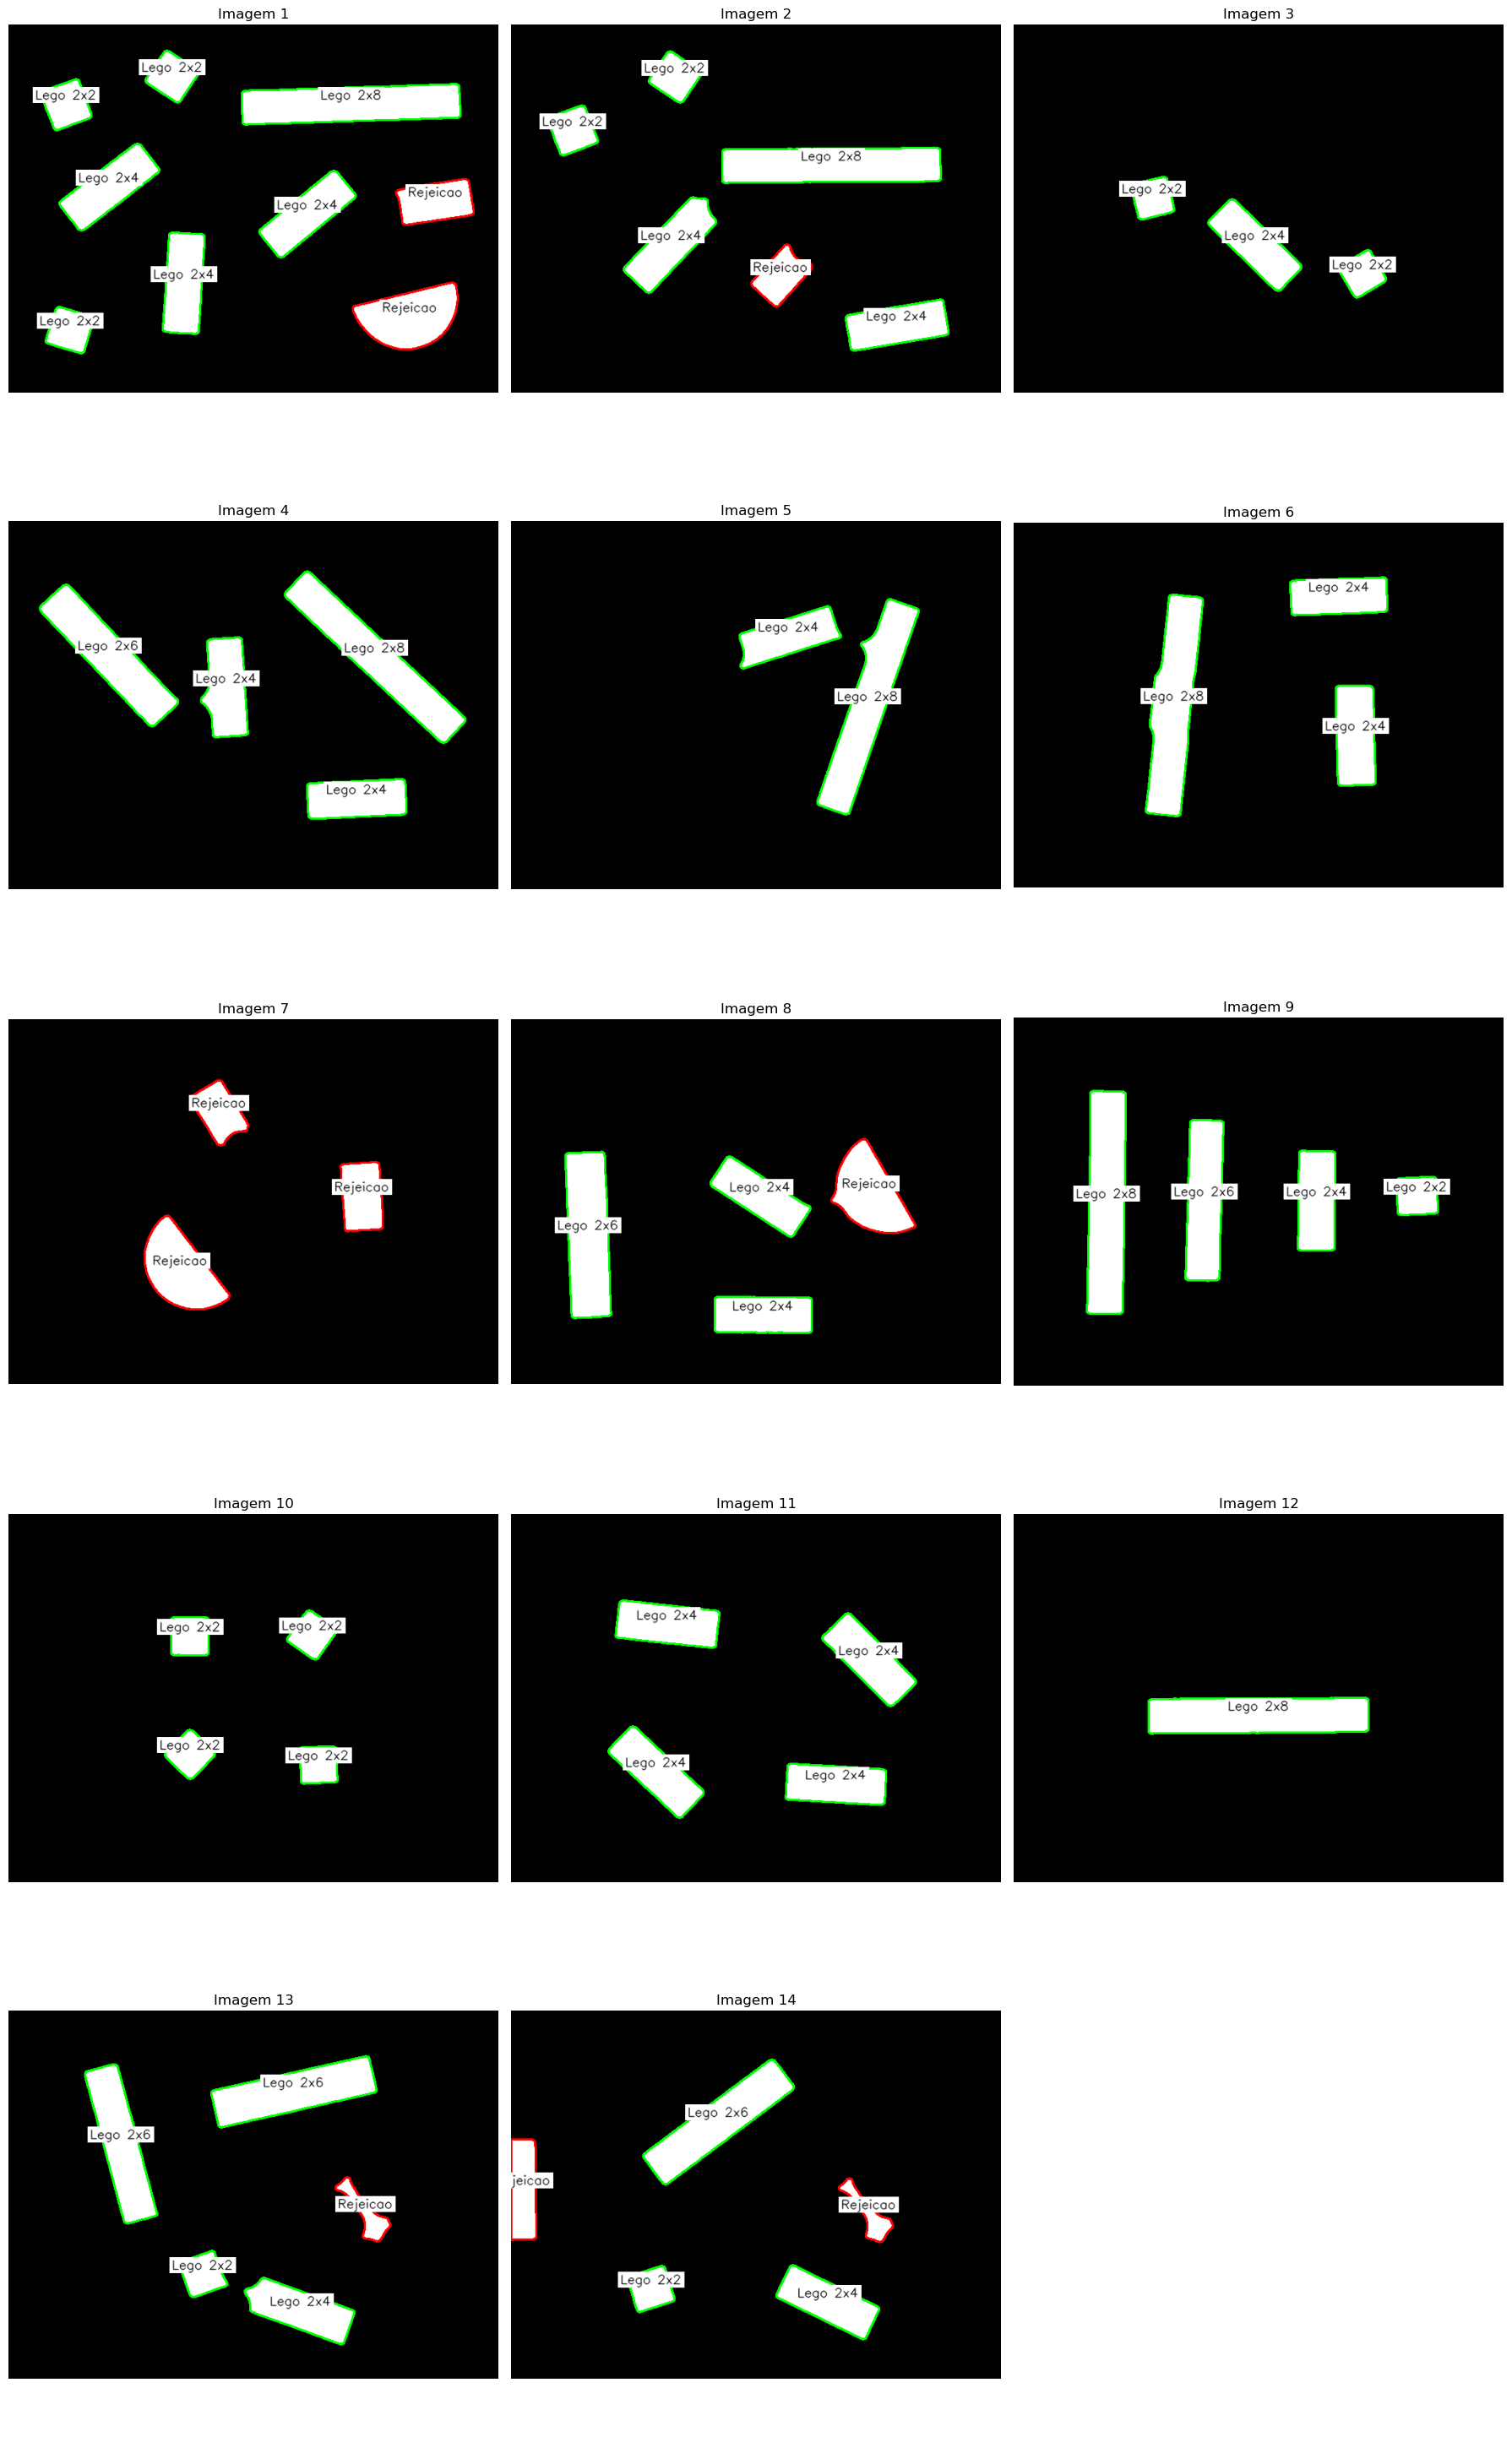

In [27]:
n = 14 # número fixo de imagens
cols = 3 # 3 imagens por linha
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))  # tamanhos maiores
axes = axes.flatten()

for i in range(rows * cols):
    ax = axes[i]
    if i >= n:
        ax.axis("off")
        continue

    # Obter imagem binária
    img_bw = updated_images[i].copy()
    contours, _ = cv2.findContours(img_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_vis = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2BGR)

    # Desenhar contornos e classes
    for c in contours:
        area = cv2.contourArea(c)
        label = lego_class(area)
        color = CLASS_COLOR.get(label, (0, 0, 255))

        # contorno
        cv2.drawContours(img_vis, [c], -1, color, 2)

        # texto centrado
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        x0, y0 = cx - tw // 2, cy - th // 2
        cv2.rectangle(img_vis, (x0 - 3, y0 - th - 3), (x0 + tw + 3, y0 + 5), (255, 255, 255), -1)
        cv2.putText(img_vis, label, (x0, y0),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)

    # Plot imagens
    ax.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Imagem {i+1}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

### 9. Avaliação do Sistema

Para avaliação do sistema recorremos a uma matriz de confusão, numa das imagens teste, a partir do calculo da Taxa Experimental de Erro (tee) e da Taxa Experimental de Rejeições (ter).

Deste modo iremos obter a avaliação do funcionamento do sistema de classificação que implementamos.

    - TEE (Taxa Experimental de Erro)


<img src="../images/tee_calc.png" alt="tee" width="400"/>


    - TER (Taxa Experimental de Rejeições)

<img src="../images/ter_calc.png" alt="tee" width="400"/>


Os resultados obtidos mostram um sistema muito preciso nas peças que decide classificar. A TEE = 0.000 indica que não houve qualquer erro nas classificações aceites com o data-set como teste.

Já os resultados obtidos na taxa experimental de rejeições chegamos a conclusão que quase 20% dos objetos classificados não pertecem ao conjunto das 4 classes pedidas no enunciado

Para evoluir este sistema, recomenda-se o aumento de features para caracterizar as peças para nao permitir a classificação de objetos de mesma area não sendo peças lego.


### 10. Conclusão

Neste primeiro trabalho prático desenvolveu-se um sistema de processamento de imagem em Python, recorrendo à biblioteca OpenCV, para identificar e classificar peças de Lego com diferentes dimensões. O método seguido envolveu várias etapas, desde a escolha do canal de cor mais adequado, a filtragem e binarização das imagens, até à aplicação de operadores morfológicos para separar peças em contacto. Posteriormente, foram extraídas as áreas de cada objeto e usadas como base para a classificação nas classes 2x2, 2x4, 2x6 e 2x8, incluindo ainda uma classe de rejeição para peças fora do padrão.

O sistema mostrou bons resultados, conseguindo distinguir corretamente todas as peças do banco de dados, mesmo em situações com sombras ou pequenas imperfeições (peças sobrepostas). No entanto, o facto de a classificação depender apenas da área limita a precisão em alguns casos, sendo possível melhorar com a introdução de novas características de classificação (features).

A realização deste trabalho permitiu consolidar vários conhecimentos sobre visão por computador, nomeadamente na segmentação e análise de formas, e na importância da escolha adequada de filtros e parâmetros morfológicos. Além disso, ajudou a compreender a relação entre teoria e prática, mostrando como pequenas decisões no processamento podem ter grande impacto no desempenho global do sistema.

### 11. Bibliografia

https://kfcdicasdigital.com/glossario/o-que-e-binarizacao-de-imagem/

https://clubedogis.com.br/glossario/o-que-e-histogramas-de-imagens-guia-completo/

https://tutoriais.edu.lat/pub/opencv/opencv-gaussian-blur/opencv-gaussian-blur

https://soescola.com/glossario/o-que-e-gaussian-blur#google_vignette